<a href="https://colab.research.google.com/github/praveentn/hgwxx7/blob/master/dl/gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks

Historically, the biggest difficulty for machine learning with molecules was the choice and computation of "descriptors". Graph neural networks (GNNs) are a category of deep neural networks whose inputs are graphs and provide a way around the choice of descriptors. A GNN can take a molecule directly as input.


```{admonition} Audience & Objectives
This chapter builds on {doc}`layers` and {doc}`../ml/regression`. Although it is defined here, it would be good to be familiarize yourself with graphs/networks. After completing this chapter, you should be able to 

  * Represent a molecule in a graph
  * Discuss and categorize common graph neural network architectures
  * Build a GNN and choose a read-out function for the type of labels
  * Distinguish between graph, edge, and node features
  * Formulate a GNN into edge-updates, node-updates, and aggregation steps
```

GNNs are specific layers that input a graph and output a graph. You can find reviews of GNNs in Dwivedi *et al.*{cite}`dwivedi2020benchmarking`, Bronstein *et al.*{cite}`bronstein2017geometric`, and  Wu *et al.*{cite}`wu2020comprehensive`. GNNs can be used for everything from coarse-grained molecular dynamics {cite}`li2020graph` to predicting NMR chemical shifts {cite}`yang2020predicting` to modeling dynamics of solids {cite}`xie2019graph`. Before we dive too deep into them, we must first understand how a graph is represented in a computer and how molecules are converted into graphs. 

You can find an interactive introductory article on graphs and graph neural networks at [distill.pub](https://distill.pub/2021/gnn-intro/) {cite}`sanchez-lengeling2021a`. Most current research in GNNs is done with specialized deep learning libraries for graphs. As of 2022, the most common are [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), [Deep Graph library](https://www.dgl.ai/), [DIG](https://github.com/divelab/DIG), [Spektral](https://graphneural.network/), and [TensorFlow GNNS](https://github.com/tensorflow/gnn).

## Representing a Graph

A graph $\mathbf{G}$ is a set of nodes $\mathbf{V}$ and edges $\mathbf{E}$. In our setting, node $i$ is defined by a vector $\vec{v}_i$, so that the set of nodes can be written as a rank 2 tensor. The edges can be represented as an adjacency matrix $\mathbf{E}$, where if $e_{ij} = 1$ then nodes $i$ and $j$ are connected by an edge. In many fields, graphs are often immediately simplified to be directed and acyclic, which simplifies things. Molecules are instead undirected and have cycles (rings). Thus, our adjacency matrices are always symmetric $e_{ij} = e_{ji}$ because there is no concept of direction in chemical bonds. Often our edges themselves have features, so that $e_{ij}$ is itself a vector. Then the adjacency matrix becomes a rank 3 tensor. Examples of edge features might be covalent bond order or distance between two nodes.


```{figure} ./methanol.jpg
----
name: methanol
width: 400px
----
Methanol with atoms numbered so that we can convert it to a graph. 
```

```{margin} one-hot
Recall that a one-hot is a vector of
all 0s and a single 1 - `[0, 1, 0, 0]`. The 
index of the non-zero element indictates the class.
In this case, class is element. 
```

Let's see how a graph can be constructed from a molecule. Consider methanol, shown in {numref}`methanol`. I've numbered the atoms so that we have an order for defining the nodes/edges. First, the node features. You can use anything for node features, but often we'll begin with one-hot encoded feature vectors:

| Node | C  | H  | O  |
|:-----|----|----|---:|
| 1    | 0  | 1  |  0 |
| 2    | 0  | 1  |  0 |
| 3    | 0  | 1  |  0 |
| 4    | 1  | 0  |  0 |
| 5    | 0  | 0  |  1 |
| 6    | 0  | 1  |  0 |

$\mathbf{V}$ will be the combined feature vectors of these nodes. The adjacency matrix $\mathbf{E}$ will look like:


|    | 1  | 2  | 3  | 4  | 5  | 6  | 
|:---|----|----|----|----|----|---:|
| 1  | 0  | 0  | 0  | 1  | 0  |  0 |
| 2  | 0  | 0  | 0  | 1  | 0  |  0 |
| 3  | 0  | 0  | 0  | 1  | 0  |  0 |
| 4  | 1  | 1  | 1  | 0  | 1  |  0 |
| 5  | 0  | 0  | 0  | 1  | 0  |  1 |
| 6  | 0  | 0  | 0  | 0  | 1  |  0 |


Take a moment to understand these two. For example, notice that rows 1, 2, and 3 only have the 4th column as non-zero. That's because atoms 1-3 are bonded only to carbon (atom 4). Also, the diagonal is always 0 because atoms cannot be bonded with themselves. 

You can find a similar process for converting crystals into graphs in Xie et al. {cite}`Xie2018Crystal`. We'll now begin with a function which can convert a smiles string into this representation.

## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages.

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell. 

```
!pip install dmol-book
```

If you find install problems, you can get the latest working versions of packages used in [this book here](https://github.com/whitead/dmol-book/blob/master/package/setup.py)

````

In [1]:
!pip install rdkit dmol-book

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import pandas as pd
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw
import networkx as nx
import dmol

In [3]:
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
np.random.seed(0)
my_elements = {6: "C", 8: "O", 1: "H"}

The hidden cell below defines our function `smiles2graph`. This creates one-hot node feature vectors for the element C, H, and O. It also creates an adjacency tensor with one-hot bond order being the feature vector.

In [4]:
def smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, len(my_elements)))
    lookup = list(my_elements.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N, 5))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v, order] = 1
        adj[v, u, order] = 1
    return nodes, adj

In [5]:
nodes, adj = smiles2graph("CO")
nodes

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

## A Graph Neural Network

A graph neural network (GNN) is a neural network with two defining attributes:

1. Its input is a graph
2. Its output is permutation equivariant

We can understand clearly the first point. Here, a graph permutation means re-ordering our nodes. In our methanol example above, we could have easily made the carbon be atom 1 instead of atom 4. Our new adjacency matrix would then be:

|    | 1  | 2  | 3  | 4  | 5  | 6  | 
|:---|----|----|----|----|----|---:|
| 1  | 0  | 1  | 1  | 1  | 1  |  0 |
| 2  | 1  | 0  | 0  | 0  | 0  |  0 |
| 3  | 1  | 0  | 0  | 0  | 0  |  0 |
| 4  | 1  | 0  | 0  | 0  | 1  |  0 |
| 5  | 1  | 0  | 0  | 0  | 0  |  1 |
| 6  | 0  | 0  | 0  | 0  | 1  |  0 |


A GNN is permutation equivariant if the output change the same way as these exchanges. If you are trying to model a per-atom quantity like partial charge or chemical shift, this is obviously essential. If you change the order of atoms input, you would expect the order of their partial charges to similarly change. 

Often we want to model a whole-molecule property, like solubility or energy. This should be **invariant** to changing the order of the atoms. To make an equivariant model invariant, we use read-outs (defined below). See {doc}`data` for a  more detailed discussion of equivariance.

### A simple GNN

We will often mention a GNN when we really mean a layer from a GNN. Most GNNs implement a specific layer that can deal with graphs, and so usually we are only concerned with this layer. Let's see an example of a simple layer for a GNN:

\begin{equation}
f_k = \sigma\left( \sum_i \sum_j v_{ij}w_{jk}  \right)
\end{equation}

This equation shows that we first multiply every node ($v_{ij}$) feature by trainable weights $w_{jk}$, sum over all node features, and then apply an activation. This will yield a single feature vector for the graph. Is this equation permutation equivariant? Yes, because the node index in our expression is index $i$ which can be re-ordered without affecting the output.

Let's see an example that is similar, but not permutation equivariant:

\begin{equation}
f_k = \sigma\left( \sum_i v_{ij}w_{ik}  \right)
\end{equation}

This is a small change. We have one weight vector per node now. This makes the trainable weights depend on the ordering of the nodes. Then if we swap the node ordering, our weights will no longer align. So if we were to input two methanol molecules, which should have the same output, but we switched two atom numbers, we would get different answers. These simple examples differ from real GNNs in two important ways: (i) they give a single feature vector output, which throws away per-node information, and (ii) they do not use the adjacency matrix. Let's see a real GNN that has these properties while maintaining permutation equivariant.

## Kipf & Welling GCN

One of the first popular GNNs was the Kipf & Welling graph convolutional network (GCN) {cite}`kipf2016semi`. Although some people consider GCNs to be a broad class of GNNs, we'll use GCNs to refer specifically the Kipf & Welling GCN. 
Thomas Kipf has written an [excellent article introducing the GCN](https://tkipf.github.io/graph-convolutional-networks/).

The input to a GCN layer is $\mathbf{V}$, $\mathbf{E}$ and it outputs an updated $\mathbf{V}'$. Each node feature vector is updated. The way it updates a node feature vector is by averaging the feature vectors of its neighbors, as determined by $\mathbf{E}$. The choice of averaging over neighbors is what makes a GCN layer permutation equivariant. Averaging over neighbors is not trainable, so we must add trainable parameters. We multiply the neighbor features by a trainable matrix before the averaging, which gives the GCN the ability to learn. In Einstein notation, this process is:

$$
v_{il} = \sigma\left(\frac{1}{d_i}e_{ij}v_{jk}w_{lk}\right)
$$ (gcn)

where $i$ is the node we're considering, $j$ is the neighbor index, $k$ is the node input feature, $l$ is the output node feature, $d_i$ is the degree of node i (which makes it an average instead of sum), $e_{ij}$ isolates neighbors so that all non-neighbor $v_{jk}$s are zero, $\sigma$ is our activation, and $w_{lk}$ is the trainable weights. This equation is a mouthful, but it truly just is the average over neighbors with a trainable matrix thrown in. One common modification is to make all nodes neighbors of themselves. This is so that the output node features $v_{il}$ depends on the input features $v_{ik}$. We do not need to change our equation, just make the adjacency matrix have $1$s on the diagonal instead of $0$ by adding the identity matrix during pre-processing.

Building understanding about the GCN is important for understanding other GNNs. You can view the GCN layer as a way to "communicate" between a node and its neighbors. The output for node $i$ will depend only on its immediate neighbors. For chemistry, this is not satisfactory. You can stack multiple layers though. If you have two layers, the output for node $i$ will include information about node $i$'s neighbors' neighbors. Another important detail to understand in GCNs is that the averaging procedure accomplishes two goals: (i) it gives permutation equivariance by removing the effect of neighbor order and (ii) it prevents a change in magnitude in node features. A sum would accomplish (i) but would cause the magnitude of the node features to grow after each layer. Of course, you could ad-hoc put a batch normalization layer after each GCN layer to keep output magnitudes stable but averaging is easy.

In [6]:
!pip3 install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4202496/45929032 bytes (9.1%)8257536/45929032 bytes (18.0%)12296192/45929032 bytes (26.8%)16457728/45929032 bytes (35.8%)20545536/45929032 bytes (44.7%)24616960/45929032 bytes (53.6%)28557312/45929032 bytes (62.2%)32595968/45929032 bytes (71.0%)35831808/45929032 bytes (78.0%)39051264/45929032 bytes (85.0%)41484288/45929032 bytes (90.3%)45588480/45929032 bytes (99.3%)

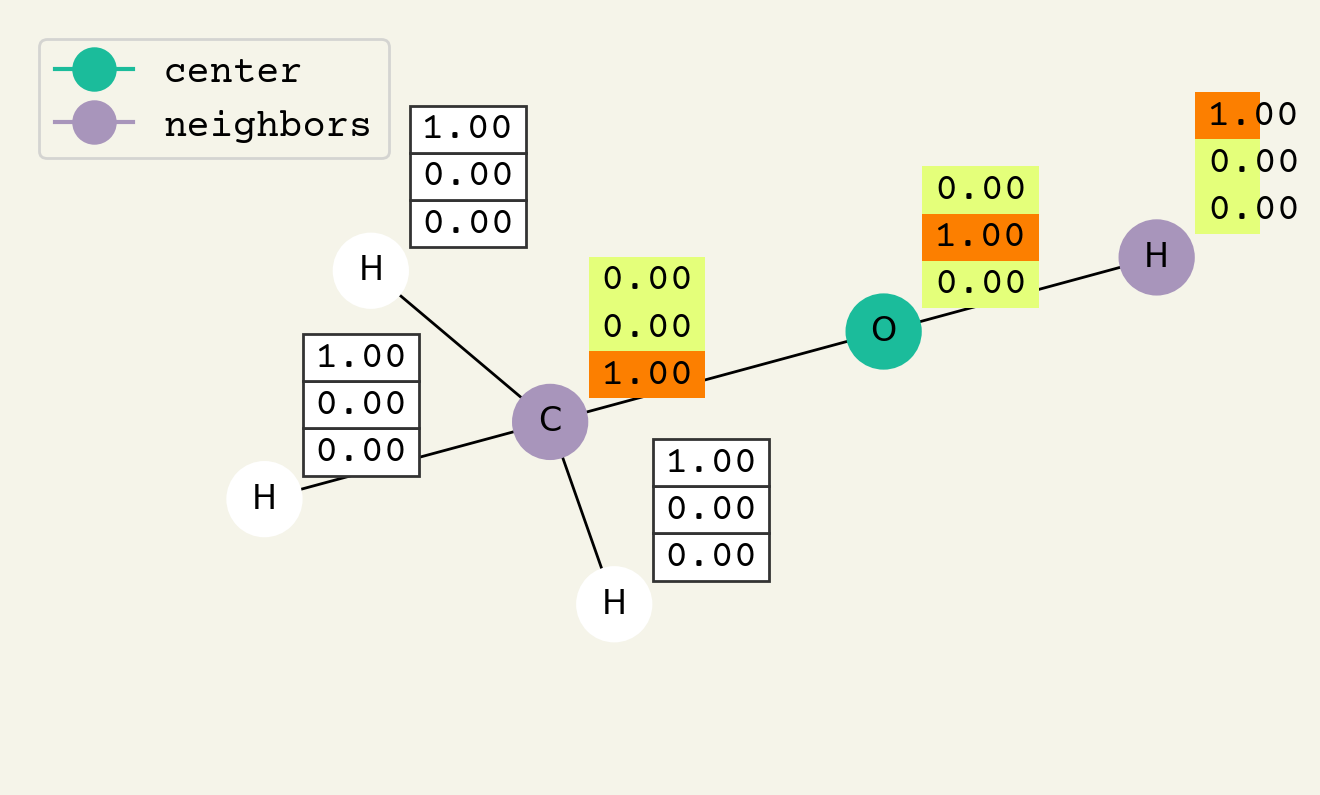

In [7]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
from myst_nb import glue
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage


def draw_vector(x, y, s, v, ax, cmap, **kwargs):
    x += s / 2
    y += s / 2
    for vi in v:
        if cmap is not None:
            ax.add_patch(
                mpl.patches.Rectangle((x, y), s * 1.5, s, facecolor=cmap(vi), **kwargs)
            )
        else:
            ax.add_patch(
                mpl.patches.Rectangle(
                    (x, y), s * 1.5, s, facecolor="#FFF", edgecolor="#333", **kwargs
                )
            )
        ax.text(
            x + s * 1.5 / 2,
            y + s / 2,
            "{:.2f}".format(vi),
            verticalalignment="center",
            horizontalalignment="center",
        )
        y += s


def draw_key(x, y, s, v, ax, cmap, **kwargs):
    x += s / 2
    y += s / 2
    for vi in v:
        ax.add_patch(
            mpl.patches.Rectangle((x, y), s * 1.5, s, facecolor=cmap(1.0), **kwargs)
        )
        ax.text(
            x + s * 1.5 / 2,
            y + s / 2,
            vi,
            verticalalignment="center",
            horizontalalignment="center",
        )
        y += s
    ax.text(
        x, y + s / 2, "Key:", verticalalignment="center", horizontalalignment="left"
    )


def draw(
    nodes, adj, ax, highlight=None, key=False, labels=None, mask=None, draw_nodes=None
):
    G = nx.Graph()
    for i in range(adj.shape[0]):
        for j in range(adj.shape[0]):
            if np.any(adj[i, j]):
                G.add_edge(i, j)
    if mask is None:
        mask = [True] * len(G)
    if draw_nodes is None:
        draw_nodes = nodes
    # go from atomic number to element
    elements = np.argmax(draw_nodes, axis=-1)
    el_labels = {i: list(my_elements.values())[e] for i, e in enumerate(elements)}
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog="sfdp")
    except ImportError:
        pos = nx.spring_layout(G, iterations=100, seed=4, k=1)
    pos = nx.rescale_layout_dict(pos)
    c = ["white"] * len(G)
    all_h = []
    if highlight is not None:
        for i, h in enumerate(highlight):
            for hj in h:
                c[hj] = "C{}".format(i + 1)
                all_h.append(hj)
    nx.draw(G, ax=ax, pos=pos, labels=el_labels, node_size=700, node_color=c)
    cmap = plt.get_cmap("Wistia")
    for i in range(len(G)):
        if not mask[i]:
            continue
        if i in all_h:
            draw_vector(*pos[i], 0.15, nodes[i], ax, cmap)
        else:
            draw_vector(*pos[i], 0.15, nodes[i], ax, None)
    if key:
        draw_key(-1, -1, 0.15, my_elements.values(), ax, cmap)
    if labels is not None:
        legend_elements = []
        for i, l in enumerate(labels):
            p = mpl.lines.Line2D(
                [0], [0], marker="o", color="C{}".format(i + 1), label=l, markersize=15
            )
            legend_elements.append(p)
        ax.legend(handles=legend_elements)
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_facecolor("#f5f4e9")


fig = plt.figure(figsize=(8, 5))
draw(nodes, adj, plt.gca(), highlight=[[1], [5, 0]], labels=["center", "neighbors"])
fig.set_facecolor("#f5f4e9")
glue("dframe", plt.gcf(), display=False)

[0] 0 5 0
[False, False, False, False, False, True] 5


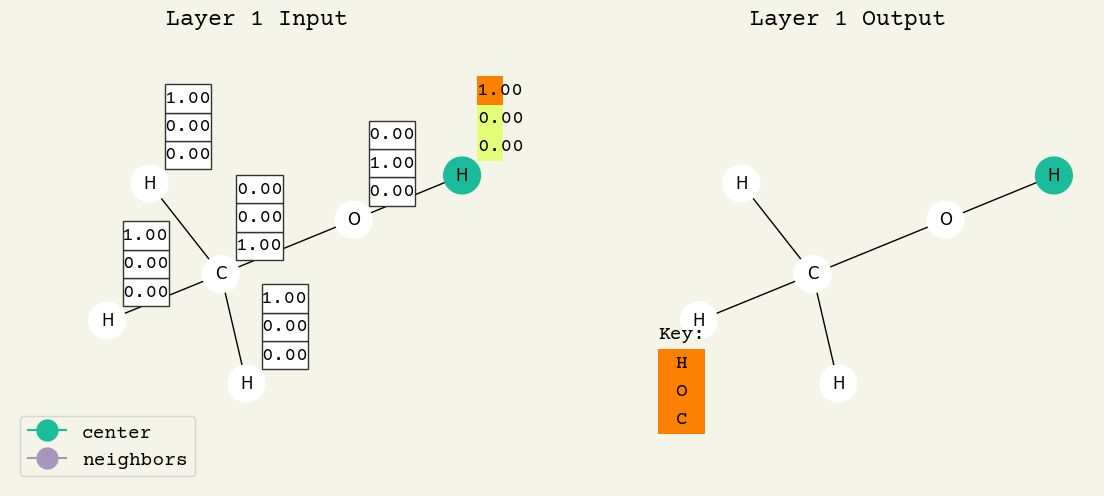

In [9]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
fig, axs = plt.subplots(1, 2, squeeze=True, figsize=(14, 6), dpi=100)
order = [5, 1, 0, 2, 3, 4]
time_per_node = 2
last_layer = [0]
layers = 2
input_nodes = np.copy(nodes)
fig.set_facecolor("#f5f4e9")


def make_frame(t):
    axs[0].clear()
    axs[1].clear()

    layer_i = int(t / (time_per_node * len(order)))
    axs[0].set_title(f"Layer {layer_i + 1} Input")
    axs[1].set_title(f"Layer {layer_i + 1} Output")

    flat_adj = np.sum(adj, axis=-1)
    out_nodes = np.einsum(
        "i,ij,jk->ik",
        1 / (np.sum(flat_adj, axis=1) + 1),
        flat_adj + np.eye(*flat_adj.shape),
        nodes,
    )

    if last_layer[0] != layer_i:
        print("recomputing")
        nodes[:] = out_nodes
        last_layer[0] = layer_i

    t -= layer_i * time_per_node * len(order)
    i = order[int(t / time_per_node)]
    print(last_layer, layer_i, i, t)
    mask = [False] * nodes.shape[0]
    for j in order[: int(t / time_per_node) + 1]:
        mask[j] = True
    print(mask, i)
    neighs = list(np.where(adj[i])[0])
    if (t - int(t / time_per_node) * time_per_node) >= time_per_node / 4:
        draw(
            nodes,
            adj,
            axs[0],
            highlight=[[i], neighs],
            labels=["center", "neighbors"],
            draw_nodes=input_nodes,
        )
    else:
        draw(
            nodes,
            adj,
            axs[0],
            highlight=[[i]],
            labels=["center", "neighbors"],
            draw_nodes=input_nodes,
        )
    if (t - int(t / time_per_node) * time_per_node) < time_per_node / 2:
        mask[j] = False
    draw(
        out_nodes,
        adj,
        axs[1],
        highlight=[[i]],
        key=True,
        mask=mask,
        draw_nodes=input_nodes,
    )
    fig.set_facecolor("#f5f4e9")
    return mplfig_to_npimage(fig)


animation = VideoClip(make_frame, duration=time_per_node * nodes.shape[0] * layers)

# animation.write_gif("../_static/images/gcn.gif", fps=2)

```{glue:figure} dframe
----
name: dframe
----
Intermediate step of the graph convolution layer. The 3D vectors are the node features and start as one-hot, so a `[1.00, 0.00, 0.00]` means hydrogen. The center node will be updated by averaging its neighbors features.
```


To help understand the GCN layer, look at {numref}`dframe`. It shows an intermediate step of the GCN layer. Each node feature is represented here as a one-hot encoded vector at input. The animation in {numref}`gcnanim` shows the averaging process over neighbor features.  To make this animation easy to follow, the trainable weights and activation functions are not considered. Note that the animation repeats for a second layer. Watch how the "information" about there being an oxygen atom in the molecule is propagated only after two layers to each atom. All GNNs operate with similar approaches, so try to understand how this animation works. 



```{figure} ../_static/images/gcn.gif
----
name: gcnanim
----
Animation of the graph convolution layer operation. The left is input, right is output node features. Note that two layers are shown (see title change). As the animation plays out, you can see how the information about the atoms propagates through the molecule via the averaging over neigbhors. So the oxygen goes from being just an oxygen, to an oxygen bonded to C and H, to an oxygen bonded to an H and CH3. The colors just reflect the same information in the numerical values.
```


### GCN Implementation

Let's now create a tensor implementation of the GCN. We'll skip the activation and trainable weights for now.
We must first compute our rank 2 adjacency matrix. The `smiles2graph` code above computes an adjacency tensor with feature vectors. We can fix that with a simple reduction and add the identity at the same time


In [10]:
nodes, adj = smiles2graph("CO")
adj_mat = np.sum(adj, axis=-1) + np.eye(adj.shape[0])
adj_mat

array([[1., 1., 1., 1., 1., 0.],
       [1., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1.]])

To compute degree of each node, we can do another reduction:

In [11]:
degree = np.sum(adj_mat, axis=-1)
degree

array([5., 3., 2., 2., 2., 2.])

Now we can put all these pieces together into the Einstein equation

In [12]:
print(nodes[0])
# note to divide by degree, make the input 1 / degree
new_nodes = np.einsum("i,ij,jk->ik", 1 / degree, adj_mat, nodes)
print(new_nodes[0])

[1. 0. 0.]
[0.2 0.2 0.6]


To now implement this as a layer in Keras, we must put this code above into a new Layer subclass. The code is relatively straightforward, but you can read-up on the function names and Layer class in [this tutorial](https://keras.io/guides/making_new_layers_and_models_via_subclassing/). The three main changes are that we create trainable parameters `self.w` and use them in the {obj}`tf.einsum`, we use an activation `self.activation`, and we output both our new node features and the adjacency matrix. The reason to output the adjacency matrix is so that we can stack multiple GCN layers without having to pass the adjacency matrix each time.

In [13]:
class GCNLayer(tf.keras.layers.Layer):
    """Implementation of GCN as layer"""

    def __init__(self, activation=None, **kwargs):
        # constructor, which just calls super constructor
        # and turns requested activation into a callable function
        super(GCNLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # create trainable weights
        node_shape, adj_shape = input_shape
        self.w = self.add_weight(shape=(node_shape[2], node_shape[2]), name="w")

    def call(self, inputs):
        # split input into nodes, adj
        nodes, adj = inputs
        # compute degree
        degree = tf.reduce_sum(adj, axis=-1)
        # GCN equation
        new_nodes = tf.einsum("bi,bij,bjk,kl->bil", 1 / degree, adj, nodes, self.w)
        out = self.activation(new_nodes)
        return out, adj

A lot of the code above is Keras/TF specific and getting the variables to the right place. There are really only two key lines here. The first is to compute the degree by summing over the columns of the adjacency matrix:

```python
degree = tf.reduce_sum(adj, axis=-1)
```

The second key line is to do the GCN equation {eq}`gcn` (without the activation)

```python
new_nodes = tf.einsum("bi,bij,bjk,kl->bil", 1 / degree, adj, nodes, self.w)
```

We can now try our layer:

In [14]:
gcnlayer = GCNLayer("relu")
# we insert a batch axis here
gcnlayer((nodes[np.newaxis, ...], adj_mat[np.newaxis, ...]))

(<tf.Tensor: shape=(1, 6, 3), dtype=float32, numpy=
 array([[[0.3563364 , 0.11872425, 0.        ],
         [0.05577278, 0.06757689, 0.        ],
         [0.        , 0.37422144, 0.        ],
         [0.        , 0.37422144, 0.        ],
         [0.        , 0.37422144, 0.        ],
         [0.5469378 , 0.        , 0.        ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
 array([[[1., 1., 1., 1., 1., 0.],
         [1., 1., 0., 0., 0., 1.],
         [1., 0., 1., 0., 0., 0.],
         [1., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 1.]]], dtype=float32)>)

It outputs (1) the new node features and (2) the adjacency matrix. Let's make sure we can stack these and apply the GCN multiple times

In [15]:
x = (nodes[np.newaxis, ...], adj_mat[np.newaxis, ...])
for i in range(2):
    x = gcnlayer(x)
print(x)

(<tf.Tensor: shape=(1, 6, 3), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        ],
        [0.        , 0.14289463, 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.14820999, 0.        ]]], dtype=float32)>, <tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
array([[[1., 1., 1., 1., 1., 0.],
        [1., 1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 1.]]], dtype=float32)>)


It works! Why do we see zeros though? Probably because we had negative numbers that were removed by our ReLU activation. This will be solved by training and increasing our dimension number. 

## Solubility Example

We'll now revisit predicting solubility with GCNs. Remember before that we used the features included with the dataset. Now we can use the molecular structures directly. Our GCN layer outputs node-level features. To predict solubility, we need to get a graph-level feature. We'll see later how to be more sophisticated in this process, but for now let's just take the average over all node features after our GCN layers. This is simple, permutation invariant, and gets us from node-level to graph level. Here's an implementation of this

In [16]:
class GRLayer(tf.keras.layers.Layer):
    """A GNN layer that computes average over all node features"""

    def __init__(self, name="GRLayer", **kwargs):
        super(GRLayer, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        nodes, adj = inputs
        reduction = tf.reduce_mean(nodes, axis=1)
        return reduction

The key line in that code is to just to compute the mean over the nodes (`axis=1`):

```python
reduction = tf.reduce_mean(nodes, axis=1)
```


To complete our deep solubility predictor, we can add some dense layers and make sure we have a single-output without activation since we're doing regression. Note this model is defined using the [Keras functional API](https://keras.io/guides/functional_api/) which is necessary when you have multiple inputs. 

In [17]:
ninput = tf.keras.Input(
    (
        None,
        100,
    )
)
ainput = tf.keras.Input(
    (
        None,
        None,
    )
)
# GCN block
x = GCNLayer("relu")([ninput, ainput])
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
# reduce to graph features
x = GRLayer()(x)
# standard layers (the readout)
x = tf.keras.layers.Dense(16, "tanh")(x)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=(ninput, ainput), outputs=x)

where does the 100 come from? Well, this dataset has lots of elements so we cannot use our size 3 one-hot encodings because we'll have more than 3 unique elements. We previously only had C, H and O. This is a good time to update our `smiles2graph` function to deal with this.

In [18]:
def gen_smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, 100))
    for i in m.GetAtoms():
        nodes[i.GetIdx(), i.GetAtomicNum()] = 1

    adj = np.zeros((N, N))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v] = 1
        adj[v, u] = 1
    adj += np.eye(N)
    return nodes, adj

In [19]:
nodes, adj = gen_smiles2graph("CO")
model((nodes[np.newaxis], adj_mat[np.newaxis]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.02755669]], dtype=float32)>

```{margin}
We have switched from adjacency tensor to matrix only because a GCN cannot use edge features. Other architectures though can. 
```
It outputs one number! That's always nice to have. Now we need to do some work to get a trainable dataset. Our dataset is a little bit complex because our features are tuples of tensors($\mathbf{V}, \mathbf{E}$) so that our dataset is a tuple of tuples: $\left((\mathbf{V}, \mathbf{E}), y\right)$. We use a **generator**, which is just a python function that can return multiple times. Our function returns once for every training example. Then we have to pass it to the `from_generator` {obj}`tf.data.Dataset` constructor which requires explicit declaration of the shapes of these examples. 

In [20]:
def example():
    for i in range(len(soldata)):
        graph = gen_smiles2graph(soldata.SMILES[i])
        sol = soldata.Solubility[i]
        yield graph, sol


data = tf.data.Dataset.from_generator(
    example,
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(
        (tf.TensorShape([None, 100]), tf.TensorShape([None, None])),
        tf.TensorShape([]),
    ),
)

Whew, that's a lot. Now we can do our usual splitting of the dataset.

In [21]:
test_data = data.take(200)
val_data = data.skip(200).take(200)
train_data = data.skip(400)

And finally, time to train.

In [22]:
model.compile("adam", loss="mean_squared_error")
result = model.fit(train_data.batch(1), validation_data=val_data.batch(1), epochs=10)

Epoch 1/10
9582/9582 [==============================] - 64s 7ms/step - loss: 2.4457 - val_loss: 2.9641
Epoch 2/10
9582/9582 [==============================] - 64s 7ms/step - loss: 2.0604 - val_loss: 2.6146
Epoch 3/10
9582/9582 [==============================] - 62s 6ms/step - loss: 1.7935 - val_loss: 2.4488
Epoch 4/10
9582/9582 [==============================] - 61s 6ms/step - loss: 1.7095 - val_loss: 2.3234
Epoch 5/10
9582/9582 [==============================] - 63s 7ms/step - loss: 1.7040 - val_loss: 2.4254
Epoch 6/10
9582/9582 [==============================] - 61s 6ms/step - loss: 1.7434 - val_loss: 2.4747
Epoch 7/10
9582/9582 [==============================] - 61s 6ms/step - loss: 1.6336 - val_loss: 2.7336
Epoch 8/10
9582/9582 [==============================] - 61s 6ms/step - loss: 1.6039 - val_loss: 2.5345
Epoch 9/10
9582/9582 [==============================] - 63s 6ms/step - loss: 1.5800 - val_loss: 2.4809
Epoch 10/10
9582/9582 [==============================] - 60s 6ms/step - l

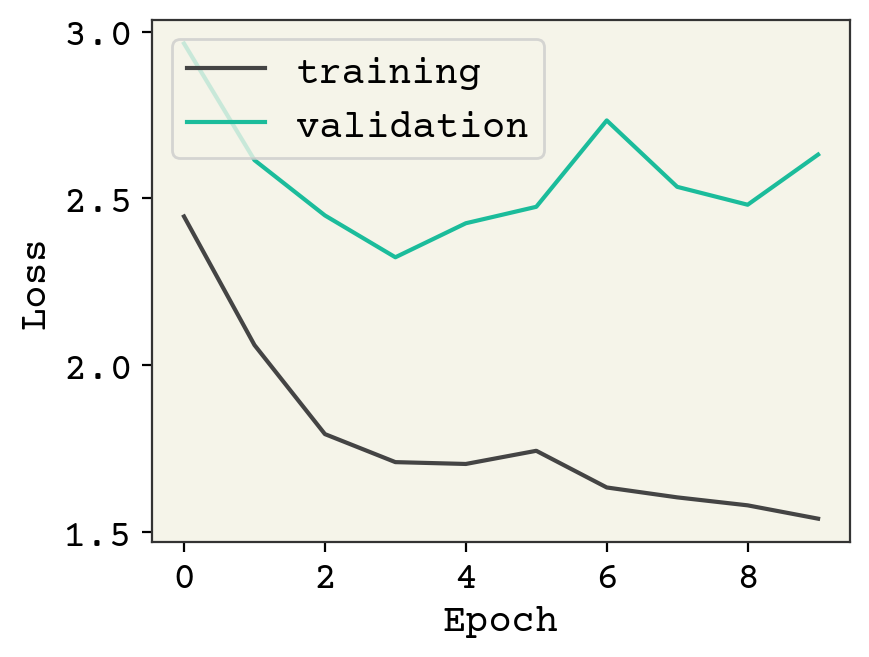

In [23]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

This model is definitely underfit. One reason is that our batch size is 1. This is a side-effect of making the number of atoms variable and then Keras/tensorflow has trouble batching together our data if there are two unknown dimensions. A standard trick is to group together multiple molecules into one graph, but making sure they are disconnected (no bonds between the molecules). That allows you to batch molecules without increasing the rank of your model/data.

Let's now check the parity plot.

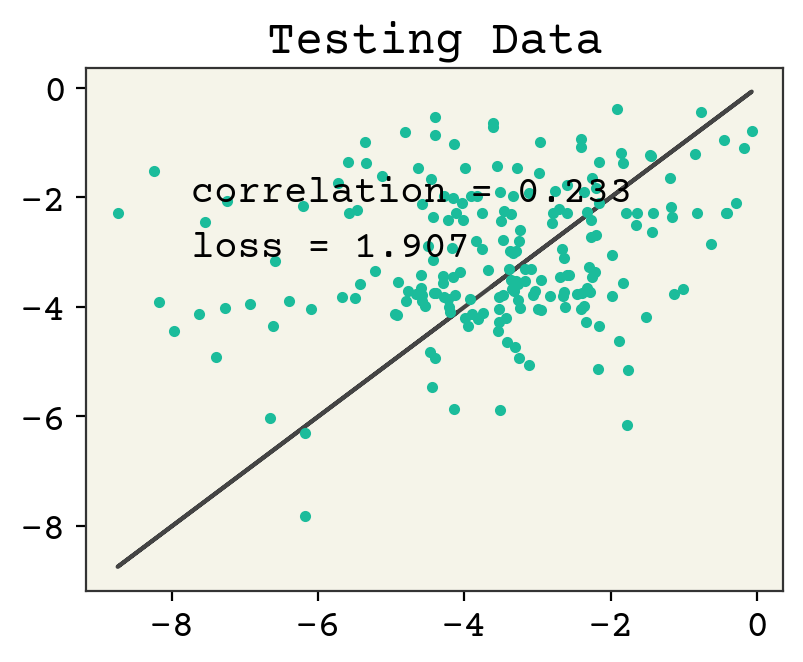

In [24]:
yhat = model.predict(test_data.batch(1), verbose=0)[:, 0]
test_y = [y for x, y in test_data]
plt.figure()
plt.plot(test_y, test_y, "-")
plt.plot(test_y, yhat, ".")
plt.text(
    min(test_y) + 1,
    max(test_y) - 2,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
)
plt.text(
    min(test_y) + 1,
    max(test_y) - 3,
    f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",
)
plt.title("Testing Data")
plt.show()

## Message Passing Viewpoint

One way to more broadly view a GCN layer is that it is a kind of "message-passing" layer. You first compute a message coming from each neighboring node:

\begin{equation}
\vec{e}_{{s_i}j} = \vec{v}_{{s_i}j} \mathbf{W}
\end{equation}

where $v_{{s_i}j}$ means the $j$th neighbor of node $i$. The $s_i$ means senders to $i$. This is how a GCN computes the messages, it's just a weight matrix times each neighbor node features. After getting the messages that will go to node $i$, $\vec{e}_{{s_i}j}$, we aggregate them using a function which is permutation invariant to the order of neighbors:

\begin{equation}
\vec{e}_{i} = \frac{1}{|\vec{e}_{{s_i}j}|}\sum \vec{e}_{{s_i}j} 
\end{equation}

In the GCN this aggregation is just a mean, but it can be any permutation invariant (possibly trainable) function. Finally, we update our node using the aggregated message in the GCN:

\begin{equation}
\vec{v}^{'}_{i} = \sigma(\vec{e}_i)
\end{equation}

where $v^{'}$ indicates the new node features. This is simply the activated aggregated message. Writing it out this way, you can see how it is possible to make small changes. One important paper by Gilmer et al. explored some of these choices and described how this general idea of message passing layers does well in learning to predict molecular energies from quantum mechanics {cite}`gilmer2017neural`. Examples of changes to the above GCN equations are to include edge information when computing the neighbor messages or use a dense neural network layer in place of $\sigma$. You can think of the GCN as one type of a broader class of message passing graph neural networks, sometimes abbreviated as MPNN.

## Gated Graph Neural Network


One common variant of the message passing layer is the **gated graph neural network** (GGN) {cite}`li2015gated`. It replaces the last equation, the node update, with

\begin{equation}
\vec{v}^{'}_{i} = \textrm{GRU}(\vec{v}_i, \vec{e}_i)
\end{equation}

where the $\textrm{GRU}(\cdot, \cdot)$ is a gated recurrent unit{cite}`chung2014empirical`. A GRU is a binary (two input arguments) neural network that is typically used in sequence modeling. The interesting property of a GGN relative to a GCN is that it has trainable parameters in the node update (from the GRU), giving the model a bit more flexibility. In a GGN, the GRU parameters are kept the same at each layer, like how a GRU is used to model sequences. What's nice about this is that you can stack infinite GGN layers without increasing the number of trainable parameters (assuming you make $\mathbf{W}$ the same at each layer). Thus GGNs are suited for large graphs, like a large protein or large unit cell.

```{margin}
You'll often see the prefix "gated" on GNNs and that means that the nodes are updated according to a GRU.
```


## Pooling

Within the message passing viewpoint, and in general for GNNS, the way that messages from neighbors are combined is a key step. This is sometimes called **pooling**, since it's similar to the pooling layer used in convolutional neural networks. Just like in pooling for convolutional neural networks, there are multiple reduction operations you can use. Typically you see a sum or mean reduction in GNNs, but you can be quite sophisticated like in the Graph Isomorphism Networks {cite}`xu2018powerful`. We'll see an example in our attention chapter of using self-attention, which can also be used for pooling. It can be tempting to focus on this step, but it's been empirically found that the choice of pooling is not so important{cite}`luzhnica2019graph,mesquita2020rethinking`. The key property of the pooling is permutation *invariance* - we want the aggregation operation to not depend on order of nodes (or edges if pooling over them). You can find a recent review of pooling methods in Grattarola et al. {cite}`grattarola2021understanding`.

You can see a more visual comparison and overview of the various pooling strategies in this distill article by Daigavane et al. {cite}`daigavane2021understanding`.

## Readout Function

GNNs output a graph by design. It is rare that our labels are graphs -- typically we have node labels or a single graph label. An example of a node label is partial charge of atoms. An example of a graph label would be the energy of the molecule. The process of converting the graph output from the GNN into our predicted node labels or graph label is called the **readout**. If we have node labels, we can simply discard the edges and use our output node feature vectors from the GNN as the prediction, perhaps with a few dense layers before our predicted output label.

If we're trying to predict a graph-level label like energy of the molecule or net charge, we need to be careful when converting from node/edge features to a graph label. If we simply put the node features into a dense layer to get to the desired shape graph label, we will lose permutation equivariance (technically it's permutation invariance now since our output is graph label, not node labels). The readout we did above in the solubility example was a reduction over the node features to get a graph feature. Then we used this graph feature in dense layers. It turns out this is the only way {cite}`zaheer2017deep` to do a graph feature readout: a reduction over nodes to get graph feature and then dense layers to get predicted graph label from those graph features. You can also do some dense layers on the node features individually, but that already happens in GNN so I do not recommend it. This readout is sometimes called DeepSets because it is the same form as the DeepSets architecture, which is a permutation invariant architecture for features that are sets{cite}`zaheer2017deep`.

You may notice that the pooling and readouts both use permutation invariant functions. Thus, DeepSets can be used for pooling and attention could be used for readouts. 

### Intensive vs Extensive

One important consideration of a readout in regression is if your labels are **intensive** or **extensive**. An intensive label is one whose value is independent of the number of nodes (or atoms). For example, the index of refraction or solubility are intensive. The readout for an intensive label should (generally) be independent of the number of a nodes/atoms. So the reduction in the readout could be a mean or max, but not a sum. In contrast, an extensive label should (generally) use a sum for the reduction in the readout. An example of an extensive molecular property is enthalpy of formation. 

## Battaglia General Equations

As you can see, message passing layers is a general way to view GNN layers. Battaglia *et al.* {cite}`battaglia2018relational` went further and created a general set of equations which captures nearly all GNNs. They broke the GNN layer equations down into 3 update equations, like the node update equation we saw in the message passing layer equations, and 3 aggregation equations (6 total equations). There is a new concept in these equations: graph feature vectors. Instead of having two parts to your network (GNN then readout), a graph level feature is updated at every GNN layer. The graph feature vector is a set of features which represent the whole graph or molecule. For example, when computing solubility it may have been useful to build up a per-molecule feature vector that is eventually used to compute solubility instead of having the readout. Any kind of per-molecule quantity, like energy, should be predicted with the graph-level feature vector. 

The first step in these equations is updating the edge feature vectors, written as $\vec{e}_k$, which we haven't seen yet:

$$
\vec{e}^{'}_k = \phi^e\left( \vec{e}_k, \vec{v}_{rk}, \vec{v}_{sk}, \vec{u}\right)
$$ (edge-update)

where $\vec{e}_k$ is the feature vector of edge $k$, $\vec{v}_{rk}$ is the receiving node feature vector for edge $k$, $\vec{v}_{sk}$ is the sending node feature vector for edge $k$, $\vec{u}$ is the graph feature vector, and $\phi^e$ is one of the three update functions that the define the GNN layer. Note that these are meant to be general expressions and you define $\phi^e$ for your specific GNN layer. 

Our molecular graphs are undirected, so how do we decide which node is receiving $\vec{v}_{rk}$ and which node is sending $\vec{v}_{sk}$? The individual $\vec{e}^{'}_k$ are aggregated in the next step as all the inputs into node $v_{rk}$. In our molecular graph, all bonds are both "inputs" and "outputs" from an atom (how else could it be?), so it makes sense to just view every bond as two directed edges: a C-H bond has an edge from C to H and an edge from H to C. In fact, our adjacency matrices already reflect that. There are two non-zero elements in them for each bond: one for C to H and one for H to C. Back to the original question, what is $\vec{v}_{rk}$ and $\vec{v}_{sk}$? We consider every element in the adjacency matrix (every $k$) and when we're on element $k = \{ij\}$, which is $A_{ij}$, then the receiving node is $j$ and the sending node is $i$. When we consider the companion edge $A_{ji}$, the receiving node is $i$ and the sending node is $j$. 

$\vec{e}^{'}_k$ is like the message from the GCN. Except it's more general: it can depend on the receiving node and the graph feature vector $\vec{u}$. The metaphor of a "message" doesn't quite apply, since a message cannot be affected by the receiver. Anyway, the new edge updates are then aggregated with the first aggregation function:

$$
\bar{e}^{'}_i = \rho^{e\rightarrow v}\left( E_i^{'}\right)
$$ (edge-aggregation)

where $\rho^{e\rightarrow v}$ is our defined function and $E_i^{'}$ represents stacking all $\vec{e}^{'}_k$ from edges  **into** node i. Having our aggregated edges, we can compute the node update:

$$
\vec{v}^{'}_i = \phi^v\left( \bar{e}^{'}_i, \vec{v}_i, \vec{u}\right)
$$ (node-update)

This concludes the usual steps of a GNN layer because we have new nodes and new edges. If you are updating the graph features ($\vec{u}$), the following additional steps may be defined:

$$
\bar{e}^{'} = \rho^{e\rightarrow u}\left( E^{'}\right)
$$ (edge-all-aggregation)

This equation aggregates all messages/aggregated edges across the whole graph. Then we can aggregate the new nodes across the whole graph:

$$
\bar{v}^{'} = \rho^{v\rightarrow u}\left( V^{'}\right)
$$ (node-all-aggregation)

Finally, we can compute the update to the graph feature vector as:

$$
\vec{u}^{'} = \phi^u\left( \bar{e}^{'},\bar{v}^{'}, \vec{u}\right)
$$ (global-update)


### Reformulating GCN into Battaglia equations

Let's see how the GCN is presented in this form. We first compute our neighbor messages for all possible neighbors using {eq}`edge-update`. Remember in the GCN, messages only depend on the senders.

```{margin}
Even though we use the "edge update" function, remember in a GCN we ignore 
the edge features. We only care edges for defining the connectivity of the graph.
```

$$
\vec{e}^{'}_k = \phi^e\left( \vec{e}_k, \vec{v}_{rk}, \vec{v}_{sk}, \vec{u}\right) = \vec{v}_{sk} \mathbf{W}
$$

To aggregate our messages coming into node $i$ in {eq}`edge-aggregation`, we average them.

$$
\bar{e}^{'}_i = \rho^{e\rightarrow v}\left( E_i^{'}\right) = \frac{1}{|E_i^{'}|}\sum E_i^{'}
$$

Our node update is then the activation {eq}`node-update`

$$
\vec{v}^{'}_i = \phi^v\left( \bar{e}^{'}_i, \vec{v}_i, \vec{u}\right) = \sigma(\bar{e}^{'}_i)
$$

we could include the self-loop above using $\sigma(\bar{e}^{'}_i + \vec{v}_i)$. The other functions are not used in a GCN, so those three completely define the GCN.

## The SchNet Architecture

One of the earliest and most popular GNNs is the SchNet network {cite}`schutt2018schnet`. It wasn't really recognized at publication time as a GNN, but its now recognized as one and you'll see it often used as a baseline model. A **baseline** model is a well-accepted and accurate model that is compared with.

```{margin} Baseline Models
A common piece of wisdom is if you want to solve a real problem with deep learning, you should read the most recent popular paper in an area and use the baseline they compare against instead of their proposed model. The reason is that a baseline model usually must be easy, fast, and well-tested, which is generally more important than being the most accurate
```

SchNet is for atoms represented as xyz coordinates (points) -- not as a molecular graph. All our previous examples used the underlying molecular graph as the input. In SchNet we will convert our xyz coodinates into a graph, so that we can apply a GNNN. SchNet was developed for predicting energies and forces from atom configurations without bond information. Thus, we need to first see how a set of atoms and their positions is converted into a graph. To get the nodes, we do a similar process as above and the atomic number is passed through an embedding layer, which is just means we assign a trainable vector to each atomic number (See {doc}`layers` for a review of embeddings). 

Getting the adjacency matrix is simple too: we just make every atom be connected to every atom. It might seem confusing what the point of using a GNN is, if we're just connecting everything. *It is because GNNs are permutation equivariant.* If we tried to do learning on the atoms as xyz coordinates, we would have weights depending on the ordering of atoms and probably fail to handle different numbers of atoms.

There is one more missing detail: where do the xyz coordinates go? We make the model depend on xyz coordinates by constructing the edge features from the xyz coordinates. The edge $\vec{e}$ between atoms $i$ and $j$ is computed purely from their distance $r$:

$$
e_k = \exp\left(-\gamma \left(r - \mu_k\right)^2\right)
$$ (rbf-edge)

where $\gamma$ is a hyperparameter (e.g., 10Å) and $\mu_k$ is an equally-space grid of scalars - like `[0, 5, 10, 15 , 20]`. The purpose of {eq}`rbf-edge` is similar to turning a category feature like atomic number or covalent bond type into a one-hot vector. We cannot do a one-hot vector though, because there is an infinite number of possible distances. Thus, we have a kind of "smoothing" that gives us a pseudo one-hot for distance. Let's see an example to get a sense of it:

In [25]:
gamma = 1
mu = np.linspace(0, 10, 5)


def rbf(r):
    return np.exp(-gamma * (r - mu) ** 2)


print("input", 2)
print("output", np.round(rbf(2), 2))

input 2
output [0.02 0.78 0.   0.   0.  ]


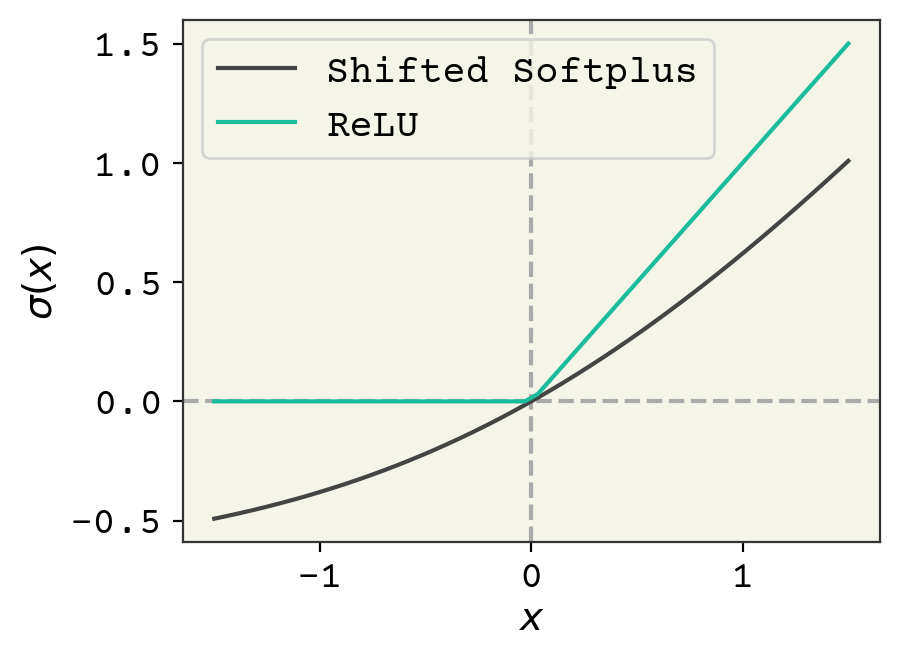

In [26]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT


def ssp(x):
    return np.log(0.5 * np.exp(x) + 0.5)


def relu(x):
    return np.where(x < 0, np.zeros_like(x), x)


plt.figure()
x = np.linspace(-1.5, 1.5)
plt.axvline(x=0, linestyle="--", color="#AAA")
plt.axhline(y=0, linestyle="--", color="#AAA")
plt.plot(x, ssp(x), label="Shifted Softplus")
plt.plot(x, relu(x), label="ReLU")
plt.xlabel("$x$")
plt.ylabel("$\sigma(x)$")
plt.legend()
glue("softplus", plt.gcf(), display=False)

You can see that a distance of $r=2$ gives a vector with most of the activation for the $k = 1$ position - which corresponds to $\mu_1 = 2$. 

We have our nodes and edges and are close to defining the GNN update equations. We need a bit more notation. I'm going to use $h(\vec{x})$ to indicate a multilayer perceptron (MLP) -- basically a 1 to 2 dense layers neural network. The exact number of dense layers and when/where activation is used in these MLPs will be defined in the implementation, because it is not so important for understanding. Recall, the definition of a dense layer is

$$
h(\vec{x}) = \sigma\left(Wx + b\right)
$$

We'll also use a different activation function $\sigma$ called "shifted softplus" in SchNet: $\ln\left(0.5e^{x} + 0.5\right)$. You can see $\sigma(x)$ compared with the usual ReLU activation in {numref}`softplus`. The rationale for using shifted softplus is that it is smooth with-respect to its input, so it could be used to compute forces in a molecular dynamics simulation which requires taking smooth derivatives with respect to pairwise distances.

```{glue:figure} softplus
----
name: softplus
----
Comparison of the usual ReLU activation function and the shifted softplus used in the SchNet model.
```

Now, the GNN equations! The edge update equation {eq}`edge-update` is composed of two pieces. First, we run the incoming edge feature through an MLP and the atoms through an MLP. Then the result is run through an MLP:

$$
\vec{e}^{'}_k = \phi^e\left( \vec{e}_k, \vec{v}_{rk}, \vec{v}_{sk}, \vec{u}\right) =h_1\left(\vec{v}_{sk}\right) \cdot h_2\left(\vec{e}_k\right)
$$

The next equation is the edge aggregation equation, {eq}`edge-aggregation`. For SchNet, the edge aggregation is a sum over the neighbor atom features.

$$
\bar{e}^{'}_i = \sum E_i^{'}
$$

Finally, the node update equation for SchNet is:

$$
\vec{v}^{'}_i = \phi^v\left( \bar{e}^{'}_i, \vec{v}_i, \vec{u}\right) = \vec{v}_i + h_3\left(\bar{e}^{'}_i\right)
$$

The GNN updates are applied typically 3-6 times. Although we have an edge update equation, like in GCN we do not actually override the edges and keep them the same at each layer. The original SchNet was for predicting energies and forces, so a readout can be done using sum-pooling or any other strategy described above. 

These are sometimes changed, but in the original SchNet paper $h_1$ is one dense layer without activation, $h_2$ is two dense layers with activation, and $h_3$ is 2 dense layers with activation on the first and not the second.


```{admonition} What is SchNet?
The key GNN feature of a SchNet-like GNN are (1) use edge & node features in the edge update (message construction):

$$
\vec{e}^{'}_k = h_1(\vec{v}_{sk}) \cdot h_2(\vec{e}_k)
$$

where $h_i()$s are some trainable functions and (2) use a residue in the node update:

$$
\vec{v}^{'}_i = \vec{v}_i + h_3\left(\bar{e}^{'}_i\right)
$$

```

All the other details about how to featurize the edges, how deep $h_i$ is, what activation to choose, how to readout, and how to convert point clouds to graphs are about the specific SchNet model in {cite}`schutt2018schnet`. 

## SchNet Example: Predicting Space Groups

Our next example will be a SchNet model that predict space groups of points. Identifying the space group of atoms is an important part of crystal structure identification, and when doing simulations of crystallization. Our SchNet model will take as input points and output the predicted space group. This is a classification problem; specifically it is multi-class becase a set of points should only be in one space group. To simplify our plots and analysis, we will work in 2D where there are 17 possible space groups. 

Our data for this is a set of points from various point groups. The features are xyz coordinates and the label is the space group. We will not have multiple atom types for this problem. The hidden cell below loads the data and reshapes it for the example. 


In [27]:
import gzip
import pickle
import urllib

urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/master/data/sym_trajs.pb.gz",
    "sym_trajs.pb.gz",
)
with gzip.open("sym_trajs.pb.gz", "rb") as f:
    trajs = pickle.load(f)

label_str = list(set([k.split("-")[0] for k in trajs]))

# now build dataset
def generator():
    for k, v in trajs.items():
        ls = k.split("-")[0]
        label = label_str.index(ls)
        traj = v
        for i in range(traj.shape[0]):
            yield traj[i], label


data = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    ),
).shuffle(
    1000,
    reshuffle_each_iteration=False,  # do not change order each time (!) otherwise will contaminate
)

# The shuffling above is really important because this dataset is in order of labels!

val_data = data.take(100)
test_data = data.skip(100).take(100)
train_data = data.skip(200)

ValueError: ignored

Let's take a look at a few examples from the dataset

```{admonition} The Data
:class: dropdown
This data was generated from {cite}`cox2022symmetric` and all points are constrained to match the space group exactly during a molecular dynamics simulation. The trajectories were NPT with a positive pressure and followed the procedure in that paper for Figure 2. The force field is Lennard-Jones with $\sigma=1$ and $\epsilon=1$
```

TypeError: ignored

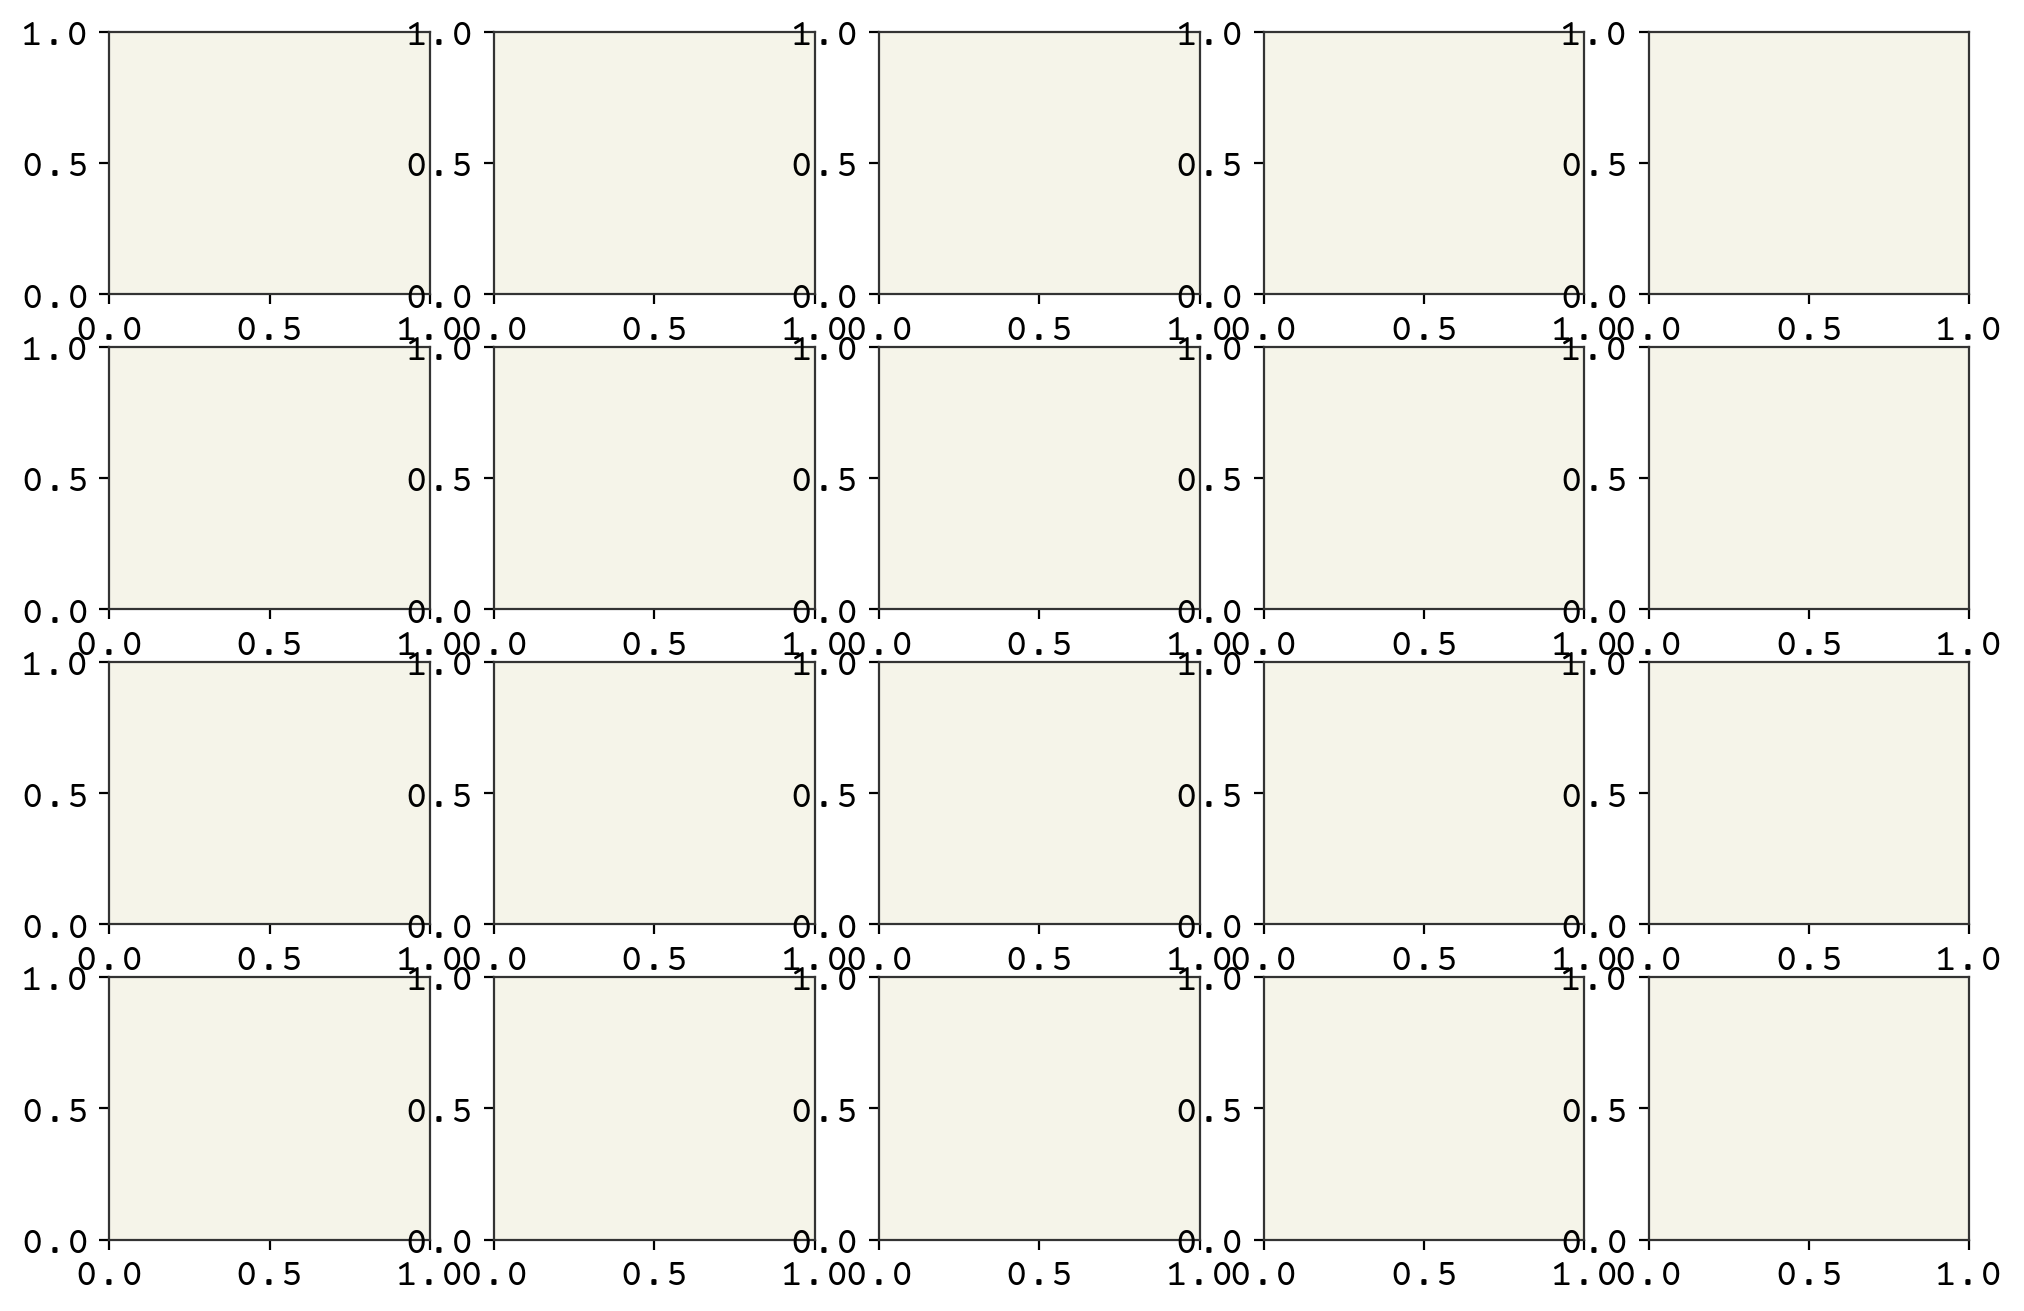

In [28]:
fig, axs = plt.subplots(4, 5, figsize=(12, 8))
axs = axs.flatten()

# get a few example and plot them
for i, (x, y) in enumerate(data):
    if i == 20:
        break
    axs[i].plot(x[:, 0], x[:, 1], ".")
    axs[i].set_title(label_str[y.numpy()])
    axs[i].axis("off")

You can see that there is a variable number of points and a few examples for each space group. The goal is to infer those titles on the plot from the points alone.

### Building the graphs

We now need to build the graphs for the points. The nodes are all identical - so they can just be 1s (we'll reserve 0 in case we want to mask or pad at some point in the future). As described in the SchNet section above, the edges should be distance to every other atom. In most implementations of SchNet, we practically add a cut-off on either distance or maximum degree (edges per node). We'll do maximum degree for this work of 16.

I have a function below that is a bit sophisticated. It takes a matrix of point positions in arbitrary dimension and returns the distances and indices to the nearest `k` neighbors - exactly what we need. It uses some tricks from {doc}`../math/tensors-and-shapes`. However, it is not so important for you to understand this function. Just know it takes in points and gives us the edge features and edge nodes.

In [ ]:
# this decorator speeds up the function by "compiling" it (tracing it)
# to run efficienty
@tf.function(
    reduce_retracing=True,
)
def get_edges(positions, NN, sorted=True):
    M = tf.shape(input=positions)[0]
    # adjust NN
    NN = tf.minimum(NN, M)
    qexpand = tf.expand_dims(positions, 1)  # one column
    qTexpand = tf.expand_dims(positions, 0)  # one row
    # repeat it to make matrix of all positions
    qtile = tf.tile(qexpand, [1, M, 1])
    qTtile = tf.tile(qTexpand, [M, 1, 1])
    # subtract them to get distance matrix
    dist_mat = qTtile - qtile
    # mask distance matrix to remove zros (self-interactions)
    dist = tf.norm(tensor=dist_mat, axis=2)
    mask = dist >= 5e-4
    mask_cast = tf.cast(mask, dtype=dist.dtype)
    # make masked things be really far
    dist_mat_r = dist * mask_cast + (1 - mask_cast) * 1000
    topk = tf.math.top_k(-dist_mat_r, k=NN, sorted=sorted)
    return -topk.values, topk.indices

Let's see how this function works by showing the connections between points in one of our examples. I've hidden the code below. It shows some point's neighbors and connects them so you can get a sense of how a set of points is converted into a graph. The complete graph will have all points' neighborhoods.

In [ ]:
from matplotlib import collections

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()
for i, (x, y) in enumerate(data):
    if i == 6:
        break
    e_f, e_i = get_edges(x, 8)

    # make things easier for plotting
    e_i = e_i.numpy()
    x = x.numpy()
    y = y.numpy()

    # make lines from origin to its neigbhors
    lines = []
    colors = []
    for j in range(0, x.shape[0], 23):
        # lines are [(xstart, ystart), (xend, yend)]
        lines.extend([[(x[j, 0], x[j, 1]), (x[k, 0], x[k, 1])] for k in e_i[j]])
        colors.extend([f"C{j}"] * len(e_i[j]))
    lc = collections.LineCollection(lines, linewidths=2, colors=colors)
    axs[i].add_collection(lc)
    axs[i].plot(x[:, 0], x[:, 1], ".")
    axs[i].axis("off")
    axs[i].set_title(label_str[y])
plt.show()

We will now add this function and the edge featurization of SchNet {eq}`rbf-edge` to get the graphs for the GNN steps.

In [ ]:
MAX_DEGREE = 16
EDGE_FEATURES = 8
MAX_R = 20

gamma = 1
mu = np.linspace(0, MAX_R, EDGE_FEATURES)


def rbf(r):
    return tf.exp(-gamma * (r[..., tf.newaxis] - mu) ** 2)


def make_graph(x, y):
    edge_r, edge_i = get_edges(x, MAX_DEGREE)
    edge_features = rbf(edge_r)
    return (tf.ones(tf.shape(x)[0], dtype=tf.int32), edge_features, edge_i), y[None]


graph_train_data = train_data.map(make_graph)
graph_val_data = val_data.map(make_graph)
graph_test_data = test_data.map(make_graph)

Let's examine one graph to see what it looks like. We'll slice out only the first nodes.

In [ ]:
for (n, e, nn), y in graph_train_data:
    print("first node:", n[1].numpy())
    print("first node, first edge features:", e[1, 1].numpy())
    print("first node, all neighbors", nn[1].numpy())
    print("label", y.numpy())
    break

### Implementing the MLPs

Now we can implement the SchNet model! Let's start with the $h_1,h_2,h_3$ MLPs that are used in the GNN update equations. In the SchNet paper these each had different numbers of layers and different decisions about which layers had activation. Let's create them now.

In [ ]:
def ssp(x):
    # shifted softplus activation
    return tf.math.log(0.5 * tf.math.exp(x) + 0.5)


def make_h1(units):
    return tf.keras.Sequential([tf.keras.layers.Dense(units)])


def make_h2(units):
    return tf.keras.Sequential(
        [
            tf.keras.layers.Dense(units, activation=ssp),
            tf.keras.layers.Dense(units, activation=ssp),
        ]
    )


def make_h3(units):
    return tf.keras.Sequential(
        [tf.keras.layers.Dense(units, activation=ssp), tf.keras.layers.Dense(units)]
    )

One detail that can be missed is that the weights in each MLP should change in each layer of SchNet. Thus, we've written the functions above to always return a new MLP. This means that a new set of trainable weights is generated on each call, meaning there is no way we could erroneously have the same weights in multiple layers.


### Implementing the GNN

Now we have all the pieces to make the GNN. This code will be very similar to the GCN example above, except we now have edge features. One more detail is that our readout will be an MLP as well, following the SchNet paper. The only change we'll make is that we want our output property to be (1) multi-class classification and (2) intensive (independent of number of atoms). So we'll end with an average (intensive) and end with an output vector of logits the size of our labels.

In [ ]:
class SchNetModel(tf.keras.Model):
    """Implementation of SchNet Model"""

    def __init__(self, gnn_blocks, channels, label_dim, **kwargs):
        super(SchNetModel, self).__init__(**kwargs)
        self.gnn_blocks = gnn_blocks

        # build our layers
        self.embedding = tf.keras.layers.Embedding(2, channels)
        self.h1s = [make_h1(channels) for _ in range(self.gnn_blocks)]
        self.h2s = [make_h2(channels) for _ in range(self.gnn_blocks)]
        self.h3s = [make_h3(channels) for _ in range(self.gnn_blocks)]
        self.readout_l1 = tf.keras.layers.Dense(channels // 2, activation=ssp)
        self.readout_l2 = tf.keras.layers.Dense(label_dim)

    def call(self, inputs):
        nodes, edge_features, edge_i = inputs
        # turn node types as index to features
        nodes = self.embedding(nodes)
        for i in range(self.gnn_blocks):
            # get the node features per edge
            v_sk = tf.gather(nodes, edge_i)
            e_k = self.h1s[i](v_sk) * self.h2s[i](edge_features)
            e_i = tf.reduce_sum(e_k, axis=1)
            nodes += self.h3s[i](e_i)
        # readout now
        nodes = self.readout_l1(nodes)
        nodes = self.readout_l2(nodes)
        return tf.reduce_mean(nodes, axis=0)

Remember that the key attributes of a SchNet GNN are the way that we use edge and node features. We can see the mixing of these two in the key line for computing the edge update (computing message values):

```python
e_k = self.h1s[i](v_sk) * self.h2s[i](edge_features)
```

followed by aggregation of the edges updates (pooling messages):

```python
e_i = tf.reduce_sum(e_k, axis=1)
```

and the node update

```python
nodes += self.h3s[i](e_i)
```

Also of note is how we go from node features to multi-classs. We use dense layers that get the shape per-node into the number of classes

```python
self.readout_l1 = tf.keras.layers.Dense(channels // 2, activation=ssp)
self.readout_l2 = tf.keras.layers.Dense(label_dim)
```

and then we take the average over all nodes

```python
return tf.reduce_mean(nodes, axis=0)
```

---

Let's give now use the model on some data.

In [ ]:
small_schnet = SchNetModel(3, 32, len(label_str))

In [ ]:
for x, y in graph_train_data:
    yhat = small_schnet(x)
    break
print(yhat.numpy())

The output is the correct shape and remember it is logits. To get a class prediction that sums to probability 1, we need to use a softmax:

In [ ]:
print("predicted class", tf.nn.softmax(yhat).numpy())

### Training

Great! It is untrained though. Now we can set-up training. Our loss will be cross-entropy from logits, but we need to be careful on the form. Our labels are integers - which is called "sparse" labels because they are not full one-hots. Mult-class classification is also known as categorical classification. Thus, the loss we want is sparse categorical cross entropy from logits.

In [ ]:
small_schnet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics="sparse_categorical_accuracy",
)
result = small_schnet.fit(graph_train_data, validation_data=graph_val_data, epochs=20)

In [ ]:
plt.plot(result.history["sparse_categorical_accuracy"], label="training accuracy")
plt.plot(result.history["val_sparse_categorical_accuracy"], label="validation accuracy")
plt.axhline(y=1 / 17, linestyle="--", label="random")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

The accuracy is not great, but it looks like we could keep training. We have a very small SchNet here. Standard SchNet described in {cite}`schutt2018schnet` uses 6 layers and 64 channels and 300 edge features. We have 3 layers and 32 channels. Nevertheless, we're able to get some learning. Let's visually see what's going on with the trained model on some test data

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(12, 8))
axs = axs.flatten()

for i, ((x, y), (gx, _)) in enumerate(zip(test_data, graph_test_data)):
    if i == 20:
        break
    axs[i].plot(x[:, 0], x[:, 1], ".")
    yhat = small_schnet(gx)
    yhat_i = tf.math.argmax(tf.nn.softmax(yhat)).numpy()
    axs[i].set_title(f"True: {label_str[y.numpy()]}\nPredicted: {label_str[yhat_i]}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()

We'll revisit this example later! One unique fact about this dataset is that it is *synthetic*, meaning there is no label noise. As discussed in {doc}`../ml/regression`, that removes the possibility of overfitting and leads us to favor high variance models. The goal of teaching a model to predict space groups is to apply it on real simulations or microscopy data, which will certainly have noise. We could have mimicked this by adding noise to the labels in the data and/or by randomly removing atoms to simulate defects. This would better help our model work in a real setting. 

## Current Research Directions

### Common Architecture Motifs and Comparisons

We've now seen message passing layer GNNs, GCNs, GGNs, and the generalized Battaglia equations. You'll find common motifs in the architectures, like gating, {doc}`attention`, and pooling strategies. For example, Gated GNNS (GGNs) can be combined with attention pooling to create Gated Attention GNNs (GAANs){cite}`zhang2018gaan`. GraphSAGE is a similar to a GCN but it samples when pooling, making the neighbor-updates of fixed dimension{cite}`hamilton2017inductive`. So you'll see the suffix "sage" when you sample over neighbors while pooling. These can all be represented in the Battaglia equations, but you should be aware of these names. 

The enormous variety of architectures has led to work on identifying the "best" or most general GNN architecture {cite}`dwivedi2020benchmarking,errica2019fair,shchur2018pitfalls`. Unfortunately, the question of which GNN architecture is best is as difficult as "what benchmark problems are best?" Thus there are no agreed-upon conclusions on the best architecture. However, those papers are great resources on training, hyperparameters, and reasonable starting guesses and I highly recommend reading them before designing your own GNN. There has been some theoretical work to show that simple architectures, like GCNs, cannot distinguish between certain simple graphs {cite}`xu2018powerful`. How much this practically matters depends on your data. Ultimately, there is so much variety in hyperparameters, data equivariances, and training decisions that you should think carefully about how much the GNN architecture matters before exploring it with too much depth. 

### Nodes, Edges, and Features

You'll find that most GNNs use the node-update equation in the Battaglia equations but do not update edges. For example, the GCN will update nodes at each layer but the edges are constant. Some recent work has shown that updating edges can be important for learning when the edges have geometric information, like if the input graph is a molecule and the edges are distance between the atoms {cite}`klicpera2019directional`. As we'll see in the chapter on equivariances ({doc}`../dl/data`), one of the key properties of neural networks with point clouds (i.e., Cartesian xyz coordinates) is to have rotation equivariance. {cite}`klicpera2019directional` showed that you can achieve this if you do edge updates and encode the edge vectors using a rotation equivariant basis set with spherical harmonics and Bessel functions. These kind of edge updating GNNs can be used to predict protein structure {cite}`jing2020learning`.

Another common variation on node features is to pack more into node features than just element identity. In many examples, you will see people inserting valence, elemental mass, electronegativity, a bit indicating if the atom is in a ring, a bit indicating if the atom is aromatic, etc. Typically these are unnecessary, since a model should be able to learn any of these features which are computed from the graph and node elements. However, we and others have empirically found that some can help, specifically indicating if an atom is in a ring {cite}`li2020graph`. Choosing extra features to include though should be at the bottom of your list of things to explore when designing and using GNNs.

### Beyond Message Passing

One of the common themes of GNN research is moving "beyond message passing," where message passing is the message construction, aggregation, and node update with messages. Some view this as impossible -- claiming that all GNNs can be recast as message passing {cite}`velivckovic2022message`. Another direction is on disconnecting the underlying graph being input to the GNN and the graph used to compute updates. We sort of saw this above with SchNet, where we restricted the maximum degree for the message passing. More useful are ideas like "lifting" the graphs into more structured objects like simplicial complexes {cite}`bodnar2021weisfeiler`. Finally, you can also choose where to send the messages beyond just neighbors {cite}`thiede2021autobahn`. For example, all nodes on a path could communicate messages or all nodes in a clique. 

### Do we need graphs?

It is possible to convert a graph into a string if you're working with an adjacency matrix without continuous values. Molecules specifically can be converted into a string. This means you can use layers for sequences/strings (e.g., recurrent neural networks or 1D convolutions) and avoid the complexities of a graph neural network. SMILES is one way to convert molecular graphs into strings. With SMILES, you cannot predict a per-atom quantity and thus a graph neural network is required for atom/bond labels. However, the choice is less clear for per-molecule properties like toxicity or solubility. There is no consensus about if a graph or string/SMILES representation is better. SMILES can exceed certain graph neural networks in accuracy on some tasks. SMILES is typically better on generative tasks. Graphs obviously beat SMILES in label representations, because they have granularity of bonds/edges.  We'll see how to model SMILES in {doc}`NLP`, but it is an open question of which is better.


### Stereochemistry/Chiral Molecules

Stereochemistry is fundamentally a 3D property of molecules and thus not present in the covalent bonding. It is measured experimentally by seeing if molecules rotate polarized light and a molecule is called chiral or "optically active" if it is experimentally known to have this property. Stereochemistry is the categorization of how molecules can preferentially rotate polarized light through asymmetries with respect to their mirror images. In organic chemistry, the majority of stereochemistry is of enantiomers. Enantiomers are "handedness" around specific atoms called chiral centers which have 4 or more different bonded atoms. These may be treated in a graph by indicating which nodes are chiral centers (nodes) and what their state or mixture of states (racemic) are. This can be treated as an extra processing step. Amino acids and thus all proteins are entaniomers with only one form present. This chirality of proteins means many drug molecules can be more or less potent depending on their stereochemistry. 


```{figure} ../_static/images/helicene.mp4
----
name: helicene
width: 500px
class: autoplay-video
----
This is a molecule with axial stereochemistry. Its small helix could be either left or right-handed. 
```

Adding node labels is not enough generally. Molecules can interconvert between stereoisomers at chiral centers through a process called tautomerization. There are also types of stereochemistry that are not at a specific atom, like rotamers that are around a bond. Then there is stereochemistry that involves multiple atoms like axial helecene. As shown in {numref}`helicene`, the molecule has no chiral centers but is "optically active" (experimentally measured to be chiral) because of its helix which can be left- or right-handed. 

## Relevant Videos

### Intro to GNNs

<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/uF53xsT7mjc" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### Overview of GNN with Molecule, Compiler Examples

<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/zCEYiCxrL_0" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>


## Chapter Summary 

* Molecules can be represented by graphs by using one-hot encoded feature vectors that show the elemental identity of each node (atom) and an adjacency matrix that show immediate neighbors (bonded atoms).
* Graph neural networks are a category of deep neural networks that have graphs as inputs.
* One of the early GNNs is the Kipf & Welling GCN. The input to the GCN is the node feature vector and the adjacency matrix, and returns the updated node feature vector. The main reason a GCN is *permutation equivariant* is because it pools over each nodes' neighbors in a permutation *invariant* way (e.g., averaging). 
* A GCN can be viewed as a message-passing layer, in which we have senders and receivers. Messages are computed from neighboring nodes, which when aggregated update that node. 
* A gated graph neural network is a variant of the message passing layer, for which the nodes are updated according to a gated recurrent unit function. 
* The aggregation of messages is sometimes called pooling, for which there are multiple reduction operations. 
* GNNs output a graph. To get a per-atom or per-molecule property, use a readout function. The readout depends on if your property is intensive vs extensive 
* The Battaglia equations encompasses almost all GNNs into a set of 6 update and aggregation equations.
* You can convert xyz coordinates into a graph and use a GNN like SchNet 

## Cited References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```